# Random forest predictions

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

import matplotlib.pylab as plt
plt.style.use('ggplot')

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [81]:
metaData_apartment = pd.read_json('../data/apartments_meta.json')
metaData_building = pd.read_json('../data/buildings_meta.json')
metaData_apartment.at[0, 'name'] = 'apartment_id'
metaData_building.at[0, 'name'] = 'building_id'
metaData = pd.concat([metaData_apartment, metaData_building])

train_apartment = pd.read_csv('../data/apartments_train.csv')
train_building = pd.read_csv('../data/buildings_train.csv')
train = pd.merge(train_apartment, train_building.set_index('id'), how='left', left_on='building_id', right_on='id')
# train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
# train.drop('id_y', axis=1, inplace=True)

test_apartment = pd.read_csv('../data/apartments_test.csv')
test_building = pd.read_csv('../data/buildings_test.csv')
test = pd.merge(test_apartment, test_building.set_index('id'), how='left', left_on='building_id', right_on='id')
# test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
# test.drop('id_y', axis=1, inplace=True)
test = test.fillna(test.mean())

In [82]:
####### SETTINGS ##############
test_size = 0.15
random_state_split = 42
outliers_value = 4
all_features = ['seller','area_total','area_kitchen','area_living','floor','rooms','layout','ceiling','bathrooms_shared','bathrooms_private','windows_court','windows_street','balconies','loggias','condition','phones','building_id', 'new','latitude','longitude','district','constructed','material','stories','elevator_without','elevator_passenger','elevator_service','parking','garbage_chute','heating']
features = ["area_total", "price_new", "rooms", "ceiling", "bathrooms_shared", "latitude", "longitude", "district", "constructed", "stories", "parking", "building_id"] 
n_estimators=300
criterion='mse'          #root_mean_squared_log_error
max_depth=None
min_weight_fraction_leaf=0.0
max_features='sqrt'
max_leaf_nodes=None
min_impurity_decrease=0.0
bootstrap=True
oob_score=False
n_jobs=None
random_state_model=2
verbose=0
warm_start=True
ccp_alpha=0.0
max_samples=None



<ipython-input-92-cdbf5749f387>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.sort_values('r', inplace=True)
<ipython-input-92-cdbf5749f387>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['price_new'] = price_new


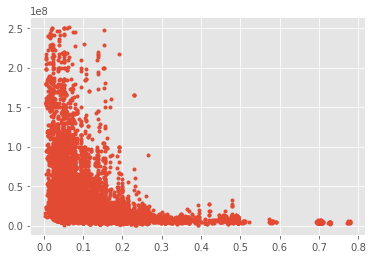

In [92]:
from sklearn.linear_model import LinearRegression
import utils

############ CLEAN DATA ###############

##### NEW POSITION
train_data_mod = train.copy()
train_data_mod["latitude"] = train_data_mod["latitude"] -  train_data_mod["latitude"].mean()
train_data_mod["longitude"] = train_data_mod["longitude"] -  train_data_mod["longitude"].mean()

# Convert to polar coordinates
train_data_mod["r"] =  np.sqrt(train_data_mod["latitude"]**2 + train_data_mod["longitude"]**2)
train_data_mod["theta"] = np.arctan(train_data_mod["longitude"]/train_data_mod["latitude"])
train = train_data_mod
train.columns

train = train[np.abs(stats.zscore(train["price"]) < 7)]
plt.plot(train['r'], train['price'], ".")


# for price in range()
trendline = np.polyfit(train['r'], (train['price']), 10)
trend = np.poly1d(trendline)
r_new = np.linspace(train['r'].min(), train['r'].max(), 23005)

train.sort_values('r', inplace=True)

price_new = trend(train['r'])

train['price_new'] = price_new

# plt.plot(r_new, price_new)
# plt.xlim([0, 0.8])
# plt.ylim([0, 0.2e9])
# plt.show()



###### MISSING VALUES
# area_living
# train = utils.fillnaReg(train, ['area_total'], 'area_living')

# # area_kitchen
# train = utils.fillnaReg(train, ['area_total', 'area_living'], 'area_kitchen')

# # ceiling
# train = utils.fillnaReg(train, ['stories'], 'ceiling')

# # district
# train = utils.fillnaReg(train, ['r', 'theta'], 'district')


In [93]:
train.fillna(train.mean(), inplace = True)
train_data, test_data = train_test_split(train, test_size=test_size, random_state=random_state_split, stratify=np.log(train.price).round())
# train_data = train_data[np.abs(stats.zscore(train_data["price"]) < 4)]
# train_data = train_data[(np.abs(stats.zscore(train_data[["rooms", "price"]], axis=0, ddof=0)) < outliers_value).all(axis=1)]              #[(np.abs(stats.zscore(train_data['price'])) < outliers_value)]
# X_train_norm = (X_train - X_train.mean())/X_train.std()
# y_train_norm = (y_train - y_train.mean())/y_train.std()
X_train, y_train = train_data[features], train_data['price']
X_test, y_test = test_data[features], test_data['price']

C:\Users\Laure\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [94]:
model2 = RandomForestRegressor(
    n_estimators=n_estimators,
    criterion=criterion,
    max_depth=max_depth,
#     min_samples_split=2,
#     min_samples_leaf=2,
    min_weight_fraction_leaf=min_weight_fraction_leaf,
    max_features=max_features,
    max_leaf_nodes=max_leaf_nodes,
    min_impurity_decrease=min_impurity_decrease,
    bootstrap=bootstrap,
    oob_score=oob_score,
    n_jobs=n_jobs,
    random_state=random_state_model,
    verbose=verbose,
    warm_start=warm_start,
    ccp_alpha=ccp_alpha,
    max_samples=max_samples
)

In [95]:
model2.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=300, random_state=2,
                      warm_start=True)

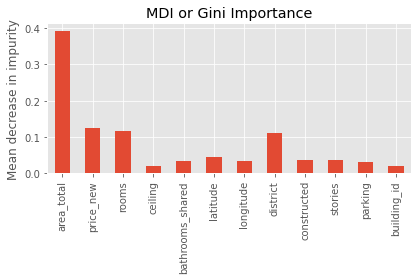

In [96]:
importances = model2.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("MDI or Gini Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Text(0.5, 1.0, 'Correlations all data')

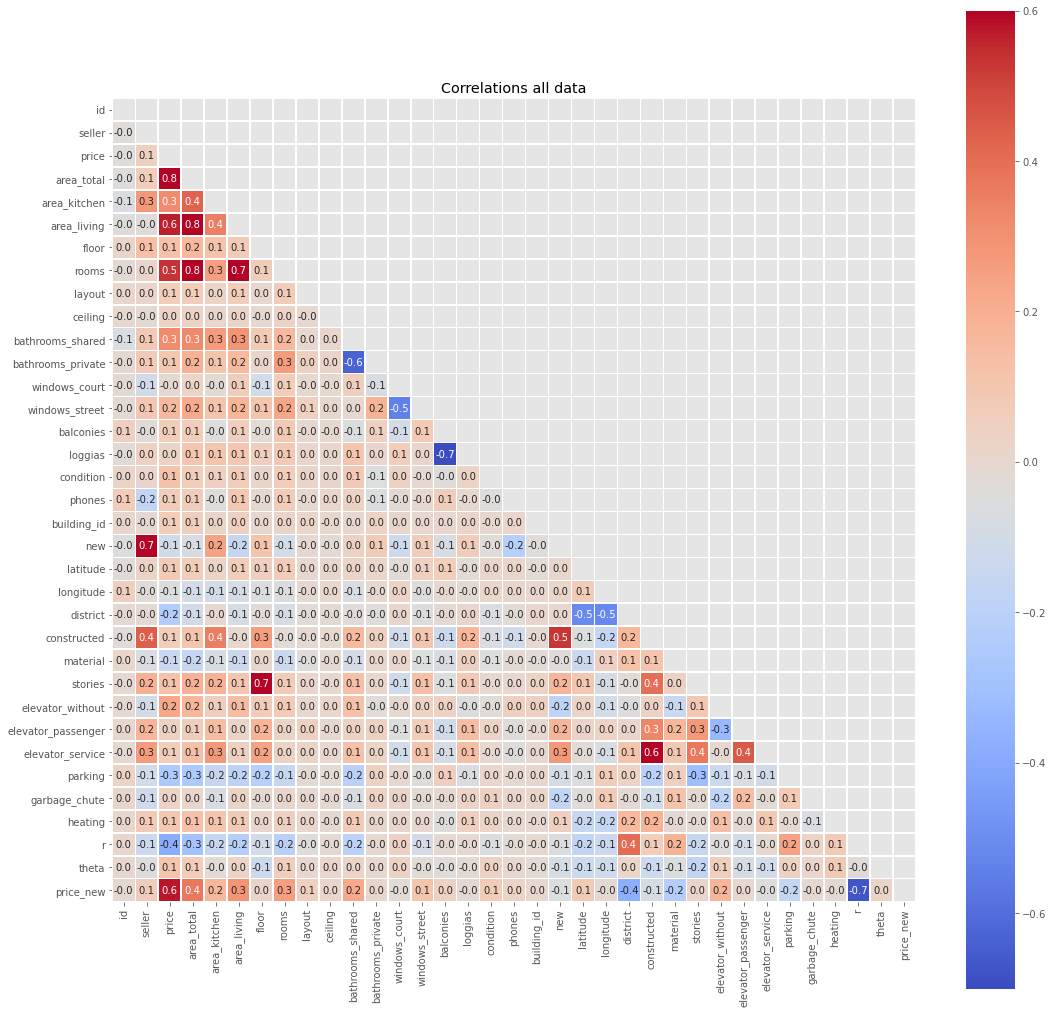

In [97]:
import seaborn as sns

corr = train_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train_data.corr(), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlations all data')

In [98]:
rf_prediction = model2.predict(X_test)
rf_mse = root_mean_squared_log_error(rf_prediction, y_test)
print('Test MSE:', rf_mse)

Test MSE: 0.15483423186271744


Text(0, 0.5, 'Ground Truth')

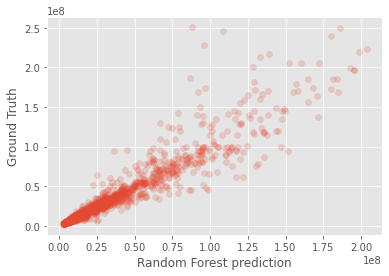

In [99]:
plt.scatter(rf_prediction, y_test, alpha=0.2)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')

In [100]:
########## Create submission
import json
# Fit model to the full dataset 

# ##### NEW POSITION
test_data_mod = test.copy()
test_data_mod["latitude"] = test_data_mod["latitude"] -  test_data_mod["latitude"].mean()
test_data_mod["longitude"] = test_data_mod["longitude"] -  test_data_mod["longitude"].mean()

# Convert to polar coordinates
test_data_mod["r"] =  np.sqrt(test_data_mod["latitude"]**2 + test_data_mod["longitude"]**2)
test_data_mod["theta"] = np.arctan(test_data_mod["longitude"]/test_data_mod["latitude"])
test = test_data_mod
test.columns


###### MISSING VALUES
# area_living
# test = utils.fillnaReg(test, ['area_total'], 'area_living')
# # area_kitchen
# test = utils.fillnaReg(test, ['area_total', 'area_living'], 'area_kitchen')
# # ceiling
# test = utils.fillnaReg(test, ['stories'], 'ceiling')
# # district
# test = utils.fillnaReg(test, ['r', 'theta'], 'district')


test = test[np.abs(stats.zscore(test["price"]) < 7)]
plt.plot(test['r'], test['price'], ".")


# for price in range()
trendline = np.polyfit(test['r'], (test['price']), 10)
trend = np.poly1d(trendline)
r_new = np.linspace(test['r'].min(), test['r'].max(), 23005)

test.sort_values('r', inplace=True)

price_new = trend(test['r'])

test['price_new'] = price_new


train = train.fillna(train.mean())
test = test.fillna(test.mean())
train = train[(np.abs(stats.zscore(train['price'])) < outliers_value)]


X_train = train[features]
y_train = train['price']
print(f'Num nans in train {X_train.isna().any(axis=1).sum()}')
model = RandomForestRegressor(max_depth=20).fit(X_train, y_train)

# Generate predictions for test set 
X_test = test[features]
X_test_nan = X_test.isna().any(axis=1)
print(f'Num nans in test: {X_test_nan.sum()}')
y_test_hat = model.predict(X_test[~X_test_nan])

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = test.id
submission.loc[~X_test_nan, 'price_prediction'] = y_test_hat # Predict on non-nan entries
submission['price_prediction'].fillna(y_train.mean(), inplace=True) # Fill missing entries with mean predictor
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers

############################################ CHANGE NAME !!!!!!!!!!
submission.to_csv('sample_RF_10.csv', index=False)
settings = {
    'train_MSE': root_mean_squared_log_error(rf_prediction, y_test),
    'features':features, 
    'outliers_value':outliers_value,
    'nan_delete':'mean',
    'test_size' : test_size,
    'random_state_split' :  random_state_split,
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_depth': max_depth,
    'min_weight_fraction_leaf': min_weight_fraction_leaf,
    'max_features': max_features,
    'max_leaf_nodes': max_leaf_nodes,
    'min_impurity_decrease': min_impurity_decrease,
    'bootstrap': bootstrap,
    'oob_score': oob_score,
    'n_jobs': n_jobs,
    'random_state': random_state_model,
    'verbose': verbose,
    'warm_start': warm_start,
    'ccp_alpha': ccp_alpha,
    'max_samples': max_samples,
    'other':'New feature price_new polynomial interpolation based on r',
    }
with open('sample_RF_10_settings.json', 'w') as fp:
    json.dump(settings, fp)